In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root, fsolve

In [2]:
plt.style.use('fivethirtyeight')

# Problem 12.8 - Fogler - 5ed

The gas-phase reversible reaction

\begin{equation}
A \leftrightarrows B
\end{equation}

is carried out under high pressure in a packed-bed reactor with pressure drop. The feed consists of both inerts **I** and Species **A** with the ratio of inerts to the species A being 2 to 1. The entering molar flow rate of A is 5 mol/min at a temperature of 300 K and a concentration of 2 mol/dm3. **Work this problem in terms of volume.**
 
_Additional information:_

Parameter | Value | Parameter | Value
- | - | - | -
Fao | 5.0 mol/min | T0 | 300 K 
CA0 | 2 mol/dm$^3$ | Ti | 300 K
CI | 2 CA0 | k (300 K) |  0.1 1/min
CpI |18 cal/mol/K | Ua | 150 cal/dm3/min/K
CPA |160 cal/mol/K | $T_{ao}$ | 300 K
E | 10,000 cal/mol | V | 40 dm$^3$
$\Delta H$Rx | −20,000 cal/mol | $\alpha \rho_b$ | 0.02 1/dm$^3$
KC(300 K) | 1,000 | | 
CPB | 160 cal/mol/K | m_c | 50 mol/min
$\rho_B$ |1.2 kg/dm3 | Cpcool | 20 cal/mol/K

Plot X, Xe, p, T, and the rate of disappearance as a function of V up to V = 40 dm3. Explain why the curves look the way they do.

1. Co-current heat exchange
2. Countercurrent heat exchange
3. Constant heat-exchanger temperature, Ta
4. Compare and constrast each of the above results and the results for adiabatic operation
2. Vary the ratio of inerts to A (0 ≤ ΘI ≤ 10) and describe what you find.
3. Plot the Qr and Ta as function of V necessary to maintain isothermal operation. 

In [3]:
# Data

Fa0 = 5.0           # initial molar flowrate A, mol/min
CA0 = 2             # initial concentration A, mol/dm$^3$ 
CI0 = 2*CA0         # initial concentration Inert, mol/dm3

T0 = 300            # initial reactor temperature, K 
Ti = 300            # inlet inert temperature, K
Ta0 = 300           # inlet coolant temperature, K 

CPA = 160           # cal/mol/K 
CPB = 160           # cal/mol/K 
CPI = 18            # cal/mol/K 
Cpcool = 20         # cal/mol/K
Ua = 150            # cal/dm3/min/K

k_300 = 0.1         # 1/min
KC_300 = 1000 
Ea = 10000          # cal/mol 
DHRx = -20000       # cal/mol 

V = 40              # dm$^3$

rho_B = 1.2         # kg/dm3 
alpha_rho_b = 0.02  # 1/dm$^3$

m_c = 50             # mol/min

Rgas = 1.987

# Preliminar calculations

In [4]:
DCp = CPB - CPA - CPI
Vo = Fa0 / CA0           # inlet volumetric flow rate, dm3/min
Fi0 = Vo * CI0

Ft0 = Fa0 + Fi0

Ct0 = Ft0 / Vo          # Initial Total Concentration

# Mathematical Model for PFR

In [5]:
def system(v, Y, parameters):
    """
      This function solves a generic case of a pfr. 
      Input:  Y - dependent variable {x: fractional conversion of A,
                                      t: reactor temperature,
                                      p: ratio P/Po,
                                      ta: coolant temperature}
              v - independent variable { v: reactor volume}
              p - parameters {phi: ratio Fi0/FAo,
                              if_adiabatic: True if reactor is adiabatic
                              how_operates_HX: 'constant' if Ta is kept constant
                                               'cocurrent' if co-current flow
                                               'countercurrent' if counter-current flow}
      Output: dx_dv, dt_dv, dp_dv, dta_dv - solution for x, t, p, and ta
    """

    x, t, p, ta = Y
    phii, if_adiabatic, how_operates_HX, if_isothermal = parameters
    
    
    v = Vo * (1/p) * (t/T0)   # total volumetric flowrate
    fa = Fa0 * (1 - x)        # molar flowrate of A
    fb = Fa0 * x              # molar flowrate of B
    fi = Fi0                  # molar flowrate of I
    
    ft = fa + fb + fi         # total molar flowrate
    
    ca = fa / v               # molar concentration of A
    cb = fb / v               # molar concentration of B
    
    # Kinetic parameters
    k = k_300 * np.exp(-Ea/Rgas * (1/t - 1/300))
    kc = KC_300 * np.exp(-DHRx/Rgas * (1/t - 1/300))
    ra = -k * (ca - cb / kc)
        
    if if_adiabatic:
        ua = 0
    else:
        ua = Ua
    
    # Energy balance inside the reactor
    qg = ra * DHRx
    qr = ua * (t - ta)
    
    # System of ODEs
    dx_dv = -ra/Fa0
    dt_dv = (qg - qr) / (Fa0 * (CPA + phii * CPI + DCp * x))
    dp_dv = -alpha_rho_b / (2 * p) * (t/T0) * (ft/Ft0)
    
    # Energy balance over the HX
    if how_operates_HX == 'constant':
        dta_dv = 0
    elif how_operates_HX == 'cocurrent':
        dta_dv = qr / (m_c * Cpcool)
    elif how_operates_HX == 'countercurrent':
        dta_dv = -qr / (m_c * Cpcool)
    elif if_isothermal:
        dta_dv = qg / (m_c * Cpcool)  
        
    return [dx_dv, dt_dv, dp_dv, dta_dv]


def get_xe_ra(x, t, p):
    
    v = Vo * (1/p) * (t/T0)   # total volumetric flowrate
    fa = Fa0 * (1 - x)        # molar flowrate of A
    fb = Fa0 * x              # molar flowrate of B
    fi = Fi0                  # molar flowrate of I
    
    ft = fa + fb + fi         # total molar flowrate
    
    ca = fa / v               # molar concentration of A
    cb = fb / v               # molar concentration of B
    
    # Kinetic parameters
    k = k_300 * np.exp(-Ea/Rgas * (1/t - 1/300))
    kc = KC_300 * np.exp(-DHRx/Rgas * (1/t - 1/300))
    ra = -k * (ca - cb / kc)
    xe = kc / (1 + kc)
    return [xe, -ra]

# Part (a) Co-current heat exchange

In [6]:
iCs = [0, T0, 1, Ta0]
Phi_i = 2
Parameters = [Phi_i, False, 'cocurrent', False]

fun = lambda v, Y: system(v, Y, Parameters)

vspan = [0, V]  #  independent variable range

solODE = solve_ivp(fun, vspan, iCs, t_eval=np.linspace(0, V), method='LSODA')

In [7]:
Vreactor_a = solODE.t
Xa_a = solODE.y[0]
Temp_reactor_a = solODE.y[1]
p_a = solODE.y[2]
Temp_coolant_a = solODE.y[3]

## Plotting the result

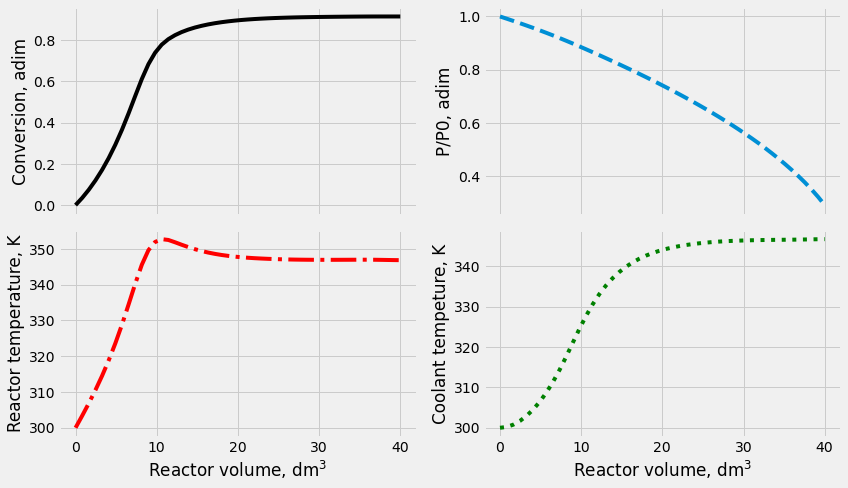

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 7), sharex=True)

ax1.plot(Vreactor_a, Xa_a, color='black')
ax1.set_ylabel('Conversion, adim')

ax2.plot(Vreactor_a, p_a, ls='--')
ax2.set_ylabel('P/P0, adim')

ax3.plot(Vreactor_a, Temp_reactor_a, color='red', ls='-.')
ax3.set_xlabel(r'Reactor volume, dm$^3$')
ax3.set_ylabel('Reactor temperature, K')

ax4.plot(Vreactor_a, Temp_coolant_a, color='green', ls=':')
ax4.set_xlabel(r'Reactor volume, dm$^3$')
ax4.set_ylabel('Coolant tempeture, K')

plt.tight_layout()
plt.show()

## Calculation of equilibrium conversion

In [9]:
Xe_a, rA_a = get_xe_ra(Xa_a, Temp_reactor_a, p_a)

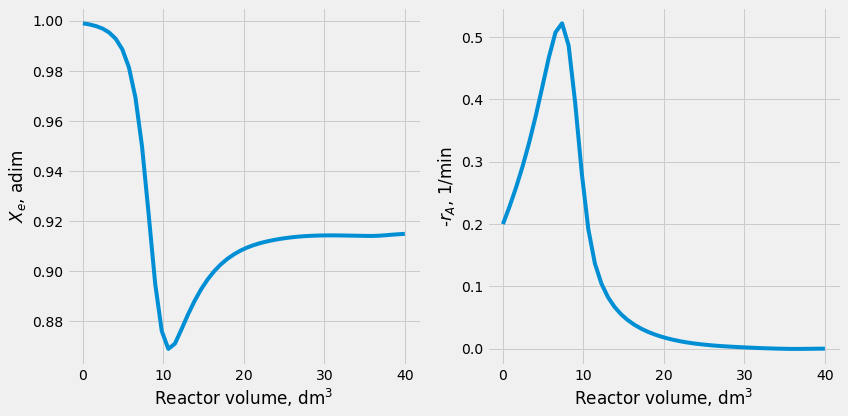

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(Vreactor_a, Xe_a)
ax1.set_xlabel(r'Reactor volume, dm$^3$')
ax1.set_ylabel(r'$X_e$, adim')

ax2.plot(Vreactor_a, rA_a)
ax2.set_xlabel(r'Reactor volume, dm$^3$')
ax2.set_ylabel(r'-$r_A$, 1/min')

plt.tight_layout()
plt.show()

# Part (b) Counter-current heat exchange

# Part (c) Constant heat-exchanger temperature, Ta

In [11]:
Parameters = [Phi_i, False, 'constant', False]

fun = lambda v, Y: system(v, Y, Parameters)

vspan = [0, V]  #  independent variable range

solODE = solve_ivp(fun, vspan, iCs, t_eval=np.linspace(0, V), method='LSODA')

Vreactor_c = solODE.t
Xa_c = solODE.y[0]
Temp_reactor_c = solODE.y[1]
p_c = solODE.y[2]
Temp_coolant_c = solODE.y[3]

Xe_c, rA_c = get_xe_ra(Xa_c, Temp_reactor_c, p_c)

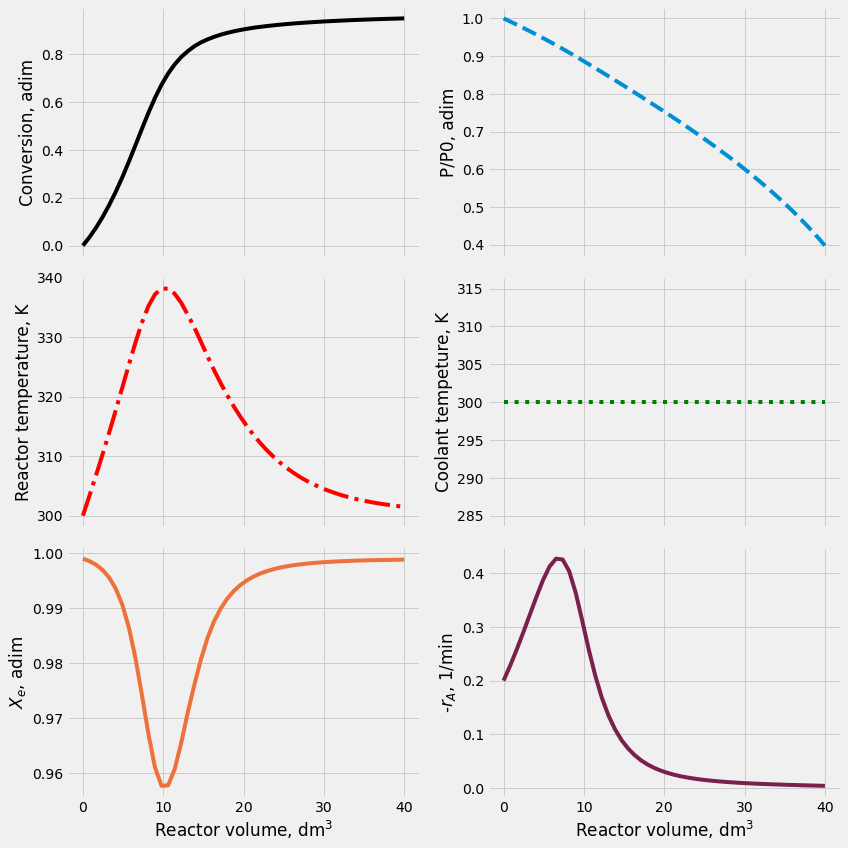

In [12]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 12), sharex=True)

ax1.plot(Vreactor_c, Xa_c, color='black')
ax1.set_ylabel('Conversion, adim')

ax2.plot(Vreactor_c, p_c, ls='--')
ax2.set_ylabel('P/P0, adim')

ax3.plot(Vreactor_c, Temp_reactor_c, color='red', ls='-.')
ax3.set_ylabel('Reactor temperature, K')

ax4.plot(Vreactor_c, Temp_coolant_c, color='green', ls=':')
ax4.set_ylabel('Coolant tempeture, K')

ax5.plot(Vreactor_c, Xe_c, color='#ed713a')
ax5.set_xlabel(r'Reactor volume, dm$^3$')
ax5.set_ylabel(r'$X_e$, adim')

ax6.plot(Vreactor_c, rA_c, color='#79204c')
ax6.set_xlabel(r'Reactor volume, dm$^3$')
ax6.set_ylabel(r'-$r_A$, 1/min')

plt.tight_layout()
plt.show()

# Part (d) Adiabatic operation

In [13]:
Parameters = [Phi_i, True, 'cocurrent', False]

fun = lambda v, Y: system(v, Y, Parameters)

vspan = [0, V]  #  independent variable range

solODE = solve_ivp(fun, vspan, iCs, t_eval=np.linspace(0, V), method='LSODA')

Vreactor_d = solODE.t
Xa_d = solODE.y[0]
Temp_reactor_d = solODE.y[1]
p_d = solODE.y[2]
Temp_coolant_d = solODE.y[3]

Xe_d, rA_d = get_xe_ra(Xa_d, Temp_reactor_d, p_d)

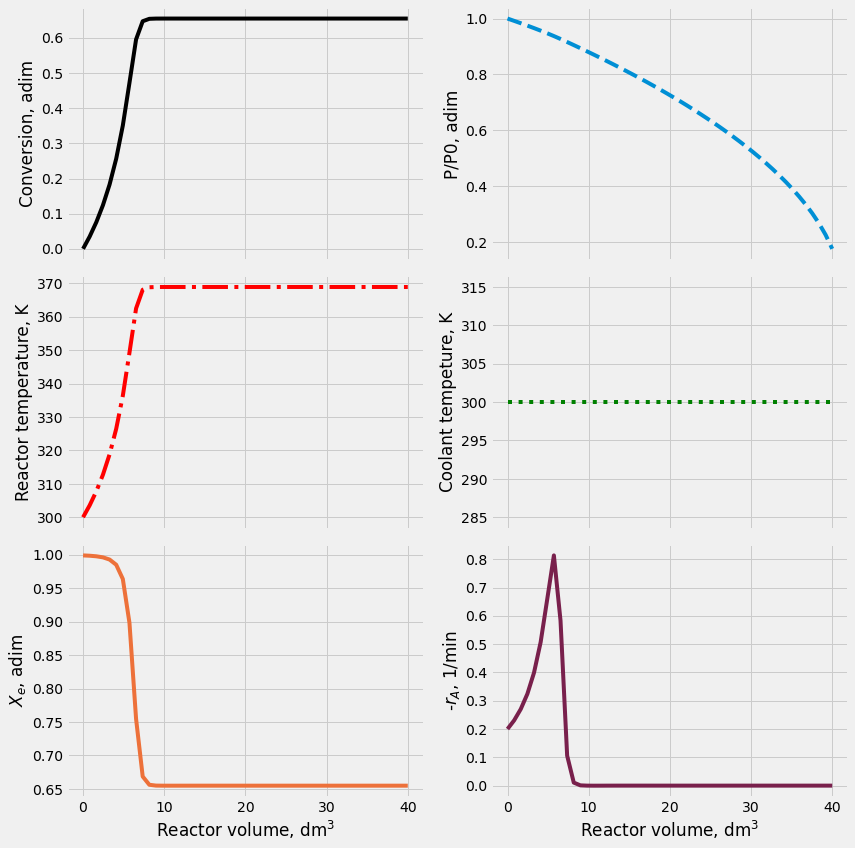

In [14]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 12), sharex=True)

ax1.plot(Vreactor_d, Xa_d, color='black')
ax1.set_ylabel('Conversion, adim')

ax2.plot(Vreactor_d, p_d, ls='--')
ax2.set_ylabel('P/P0, adim')

ax3.plot(Vreactor_d, Temp_reactor_d, color='red', ls='-.')
ax3.set_ylabel('Reactor temperature, K')

ax4.plot(Vreactor_d, Temp_coolant_d, color='green', ls=':')
ax4.set_ylabel('Coolant tempeture, K')

ax5.plot(Vreactor_d, Xe_d, color='#ed713a')
ax5.set_xlabel(r'Reactor volume, dm$^3$')
ax5.set_ylabel(r'$X_e$, adim')

ax6.plot(Vreactor_d, rA_d, color='#79204c')
ax6.set_xlabel(r'Reactor volume, dm$^3$')
ax6.set_ylabel(r'-$r_A$, 1/min')

plt.tight_layout()
plt.show()

# Part (e). Vary the ratio of inerts to 

Let's vary the ratio of inerts to A in the following values: [0, 1, 5, 10]

# Part (f). Isothermal operation

In order to operate the reactor under isothermal conditions, the removed heat should be equal to the heat generated

\begin{align}
Q_g &= r_A \, DHRx \\
Q_r &= Ua \, (T - T_a)
\end{align}

Therefore, let's modify the system of ODEs to include this change. So, 

\begin{equation}
qr = qg
\end{equation}

In [16]:
Parameters = [Phi_i, False, 'cocurrent', True]

fun = lambda v, Y: system(v, Y, Parameters)

vspan = [0, V]  #  independent variable range

solODE = solve_ivp(fun, vspan, iCs, t_eval=np.linspace(0, V), method='LSODA')

Vreactor_f = solODE.t
Xa_f = solODE.y[0]
Temp_reactor_f = solODE.y[1]
p_f = solODE.y[2]
Temp_coolant_f = solODE.y[3]

Xe_f, rA_f = get_xe_ra(Xa_f, Temp_reactor_f, p_f)

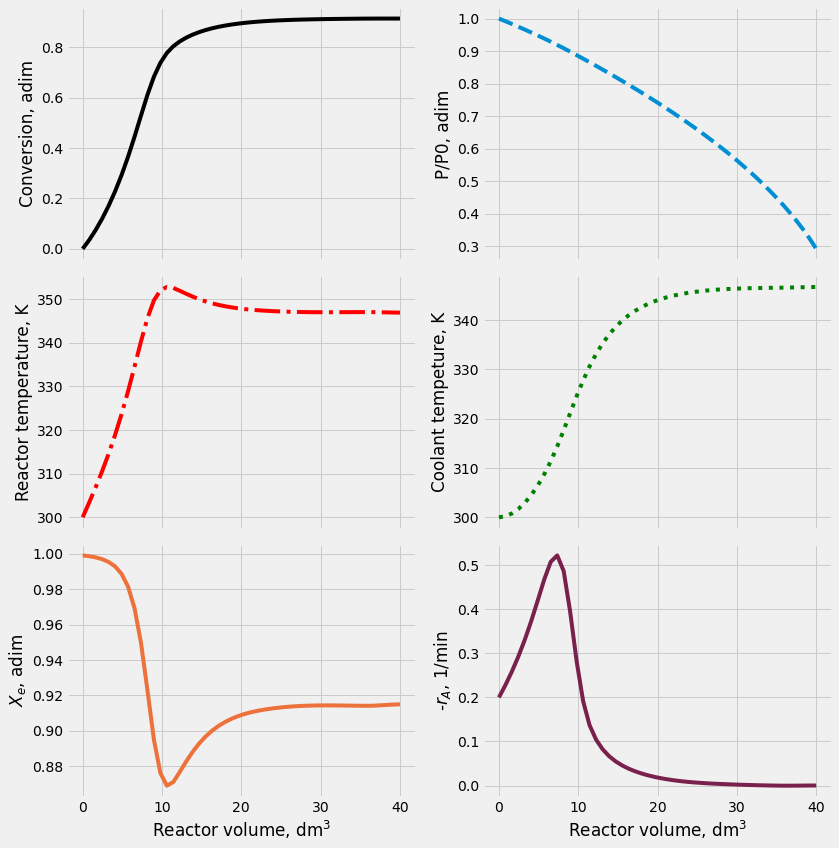

In [17]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 12), sharex=True)

ax1.plot(Vreactor_f, Xa_f, color='black')
ax1.set_ylabel('Conversion, adim')

ax2.plot(Vreactor_f, p_f, ls='--')
ax2.set_ylabel('P/P0, adim')

ax3.plot(Vreactor_f, Temp_reactor_f, color='red', ls='-.')
ax3.set_ylabel('Reactor temperature, K')

ax4.plot(Vreactor_f, Temp_coolant_f, color='green', ls=':')
ax4.set_ylabel('Coolant tempeture, K')

ax5.plot(Vreactor_f, Xe_f, color='#ed713a')
ax5.set_xlabel(r'Reactor volume, dm$^3$')
ax5.set_ylabel(r'$X_e$, adim')

ax6.plot(Vreactor_f, rA_f, color='#79204c')
ax6.set_xlabel(r'Reactor volume, dm$^3$')
ax6.set_ylabel(r'-$r_A$, 1/min')

plt.tight_layout()
plt.show()